In [325]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
text-align:center;
margin-bottom: 0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.1em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")

# Writeup



<center>Problem Statement:</center>
<br>
The question this research attempts to answer is if there is a strong connection between the words used in a Udemy course headline and the price of the course. This could help those listing courses on Udemy to write headlines, and further, pick specific topics, that best fit in with the price bracket they are aiming to sell their course in. 
<br> 

Based on the guidelines put out by Udemy, the lowest an instructor can price a course is 19.99USD, and the highest is 199.99USD. Courses can also be listed as free, and are only allowed to switch from paid to free (or vice versa) once. Courses are often put on promotional discounts, influenced by market factors. The fact that courses are not always in the same price bracket still allows for using the results of this research to be valid at the point of API call. 
<br><br>
<center>Data:</center>
<br>
The data comes from the Udemy courses API. I did a call for 5000 records each from 5 course categories. The course categories are Design, Marketing, Development, Music and Lifestyle. Not all categories had 5000 courses listed at the point of API call, so some returned less rows (see 4.1.3). 
<br>

The point of interests are the course headline, course category, and course price. The category is not included in the API result, so it is appended seperately, based on the category specified in the API call. 
In total the dataset includes 21251 rows and 4 columns: id, price, headline and category. 
<br><br>
<center>Hypothesis:</center>
<br>
I predict that there will be certain words that correlate to higher prices in courses. These words will likely correspond to hot topics at the time of the API call. There might be futher research to be done to see if these words also see a recent spike on google trends. 

ALTERNATIVE HYPOTHESIS:
The price bracket of a course can be predicted by the words in the course headline

NULL HYPOTHESIS:
The price bracket of a course cannot be predicted by the words in the course headline

Threshold: We will reject the null hypothesis if the accuracy of any model for the dataset as a whole is 25% over the baseline. (75% accurate if the baseline is 50%, for example)

<br><br>
<center>Methodology:</center>
    <br>
For this research, the course prices are segmented into 2 categories, high and low. Low courses are priced between 19.99 to (max price/2-.01)USD and high courses are priced between (max price/2-.01 USD) and 199.99USD. The category of low courses includes the midpoint cutoff, while the higher courses category does not. 
<br>

For the modeling, the course headlines are processed, cleaned of stopwords, and tokenized. Naive bayes and logistic regression classification is done on the data as a whole, and on each category individually.
<br>

<br>
<center>Results:</center>
<br>
(these results reflect the state at writing, June 1, 2020, however, running the models with the data from different api calls will give different results)
<br>
The models do not preform well, none of them surpassing 15% above the baseline, either on the data as a whole or on individual categories. 

The highest preforming model is Naive Bayes on the Development category, at 7.1% higher than baseline.
The second highest preforming model is LogisticRegression on the Development category, at 6.4% higher than baseline.

The lowest preforming model is the Multinomial Naive Bayes model for the lifestyle category, at -2.9% lower than baseline. 

For the overall dataset the logistic regression outpreforms the naive bayes in terms of accuracy above the baseline. For logisitic regression the accuracy is 4.6% higher than baseline, and for naive bayes the accuracy is 2.8% higher than baseline

For full results, see section 9.

<br>
<br>
<center>Conclusions:</center>
    <br>
There is some relation between the words in a course headline and the price bracket of that headline, however, it cannot be said to be a highly predictive variable, based on the methodology and results of this notebook. It is more predictive for some categories over other.
<br>
We do not reject the null hypothesis. 

<br>
<br>
<center>Next steps:</center>
    <br>
Refine price bracketing make ratio of price brackets more even. 
<br>Figure out how to get free courses included in API call (they were as of May 29 2020, and made the division between 1 and 0 almost 50/50 when segmenting the data at ((max/2) -.01)). 
<br>
Refine model parameters
<br>
Add more categories
<br>
Look into running nonbinary models


# Imports 

In [284]:

import json
import requests
import curl

from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup

from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from PIL import Image
from io import BytesIO


%matplotlib inline


In [73]:
sns.set(style="white", palette="muted", color_codes=True)


In [74]:
import warnings
warnings.filterwarnings('ignore')

### see documentation on how to get API access here: https://www.udemy.com/developers/affiliate/


In [75]:

import config
username= config.username
password= config.password


# Get Data

In [76]:
import requests


def get_all_course_data(max_records, category, language): 
    page_number = 1
    page_size = 100
    category=category
    language= language #specify language as english 'en'
    
    more_records_exist = True
    all_courses = []

    while more_records_exist:
        api_response = get_courses(page_number, page_size, category, language)
        results = process_response(api_response)

        # add the new results to our aggregate set
        all_courses += results
    
        # if we get back fewer records than we asked for, we know we reached the end.
        # terminate the loop if we're at the end, or have hit our max.
        if len(results) < page_size or (max_records and len(all_courses) >= max_records):
            more_records_exist = False
        else:
            page_number += 1

    return all_courses



def get_courses(page_number, page_size, category, language): 
    courses_url = "https://www.udemy.com/api-2.0/courses/"

    query_params = {
        "page_size": page_size, 
        "page": page_number ,
        "category": category,
        "language": language
    }

    credentials = (username, password)

    return requests.get(url=courses_url, auth=credentials, params=query_params).json()



def process_response(api_response):
    # api_response is a dictionary object which is a representation of the json structure.  
    courses = []

    # The json structure places all of the courses inside the results array
    for course in api_response['results']:
        # we add to the courses list tuples containing id, price, and headline.
        courses.append((course['id'], course['price'], course['headline']))
    return courses



def dataframing(result, category):
    df = pd.DataFrame.from_records(result, columns=['id', 'price', 'headline'])
    df['category']=category
    return df

In [77]:
%%time

categories=['Design','Marketing','Development','Music','Lifestyle']

df=pd.DataFrame(columns=['id', 'price', 'headline','category'])

for i in range(len(categories)):
    n = get_all_course_data(max_records=5000, category=categories[i], language='en')
    n = dataframing(n, category=categories[i])
    df = df.append([n])

    

CPU times: user 5.94 s, sys: 444 ms, total: 6.38 s
Wall time: 19min 23s


In [69]:
df.reset_index(inplace=True)


In [70]:
df.head()
df.drop(['index'],axis=1, inplace=True)
#df.drop(['level_0'],axis=1, inplace=True)


In [78]:
df.head()

,id,price,headline,category
0,874012,$149.99,Learn the #1 most important building block of ...,Design
1,1259404,$194.99,Learn How to Draw People and Character Designs...,Design
2,438522,$194.99,Use Blender to create beautiful 3D models for ...,Design
3,1197206,$199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,1065056,$194.99,"Understand your audience, envision a creative ...",Design


In [316]:
df.describe()

,id,price,headline,category
count,21251,21251,21251,21251
unique,21019,38,20615,5
top,2102060,$19.99,Learn music theory through this music theory c...,Design
freq,2,5130,15,5000


In [79]:
df.to_csv('data/data_api.csv')
#df.to_csv('data/data_n.csv')


# Clean Data 

### A description  of the dataset


In [326]:
data = pd.read_csv('data/data_api.csv')

In [327]:
data

,Unnamed: 0,id,price,headline,category
0,0,874012,$149.99,Learn the #1 most important building block of ...,Design
1,1,1259404,$194.99,Learn How to Draw People and Character Designs...,Design
2,2,438522,$194.99,Use Blender to create beautiful 3D models for ...,Design
3,3,1197206,$199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,4,1065056,$194.99,"Understand your audience, envision a creative ...",Design
...,...,...,...,...,...
21246,3476,3138350,Free,To improve your drawing and sketching techniqu...,Lifestyle
21247,3477,3152804,Free,Create 6 Step-By-Step Drawing & Watercolor Pai...,Lifestyle
21248,3478,2596152,Free,A Simple Moving Guide,Lifestyle
21249,3479,3005048,Free,В этом курсе мы нарисуем эффектный скетч разны...,Lifestyle


In [328]:
#dropping excess column created with conversion to csv
data.drop([ 'Unnamed: 0'], axis=1, inplace=True)

### data types

In [329]:
data.dtypes

id           int64
price       object
headline    object
category    object
dtype: object

In [330]:
data.category = data.category.astype(str)
data.headline = data.headline.astype(str)
data.id = data.id.astype(int)

### converting nans to 0


In [331]:
data.fillna(0, inplace=True)

### cleaning price data

In [332]:
data.price.replace({'Free': 0}, inplace=True)
data['price'] = data['price'].str.replace('$', '')
data.price = data.price.astype(float)


In [333]:
##no free courses are being included in this api call
data['price'].min()


19.99

In [334]:
data.head()

,id,price,headline,category
0,874012,149.99,Learn the #1 most important building block of ...,Design
1,1259404,194.99,Learn How to Draw People and Character Designs...,Design
2,438522,194.99,Use Blender to create beautiful 3D models for ...,Design
3,1197206,199.99,Master Adobe Illustrator CC with this in-depth...,Design
4,1065056,194.99,"Understand your audience, envision a creative ...",Design


#### columns in the dataset

In [335]:
data.columns

Index(['id', 'price', 'headline', 'category'], dtype='object')

#### categories in the dataset

In [336]:
data.category.unique()

array(['Design', 'Marketing', 'Development', 'Music', 'Lifestyle'],
      dtype=object)

## Exploratory Graphs

### course prices are not evenly distributed, spiking at the min and max

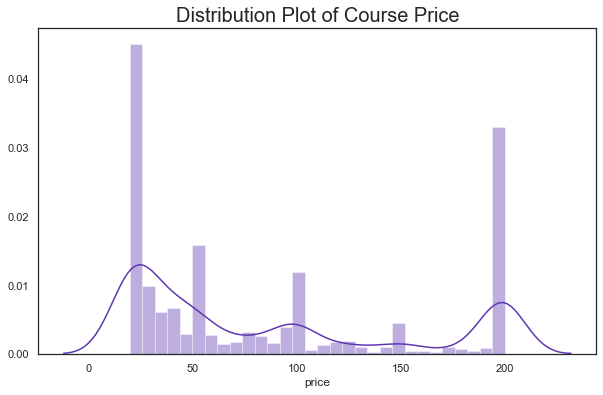

In [16]:

plt.figure(figsize= (10,6))
plt.title('Distribution Plot of Course Price', size=20)

sns.distplot(data['price'], bins=30, color='#5e35b1')
plt.show()

In [17]:
data['price'].describe()

count    14549.000000
mean        85.879752
std         68.211775
min         19.990000
25%         24.990000
50%         49.990000
75%        149.990000
max        199.990000
Name: price, dtype: float64

### category counts: Count is less than 5000 in cases where there are less than 5000 records available with these parameters from the API


In [122]:
data['category'].value_counts()


Design         5000
Marketing      5000
Development    5000
Lifestyle      3481
Music          2770
Name: category, dtype: int64

In [107]:
cat_counts = data['category'].value_counts().rename_axis('Category').reset_index(name='counts')

In [108]:
cat_counts

,Category,counts
0,Design,5000
1,Marketing,5000
2,Development,5000
3,Lifestyle,3481
4,Music,2770


### Pie Chart of Category Counts


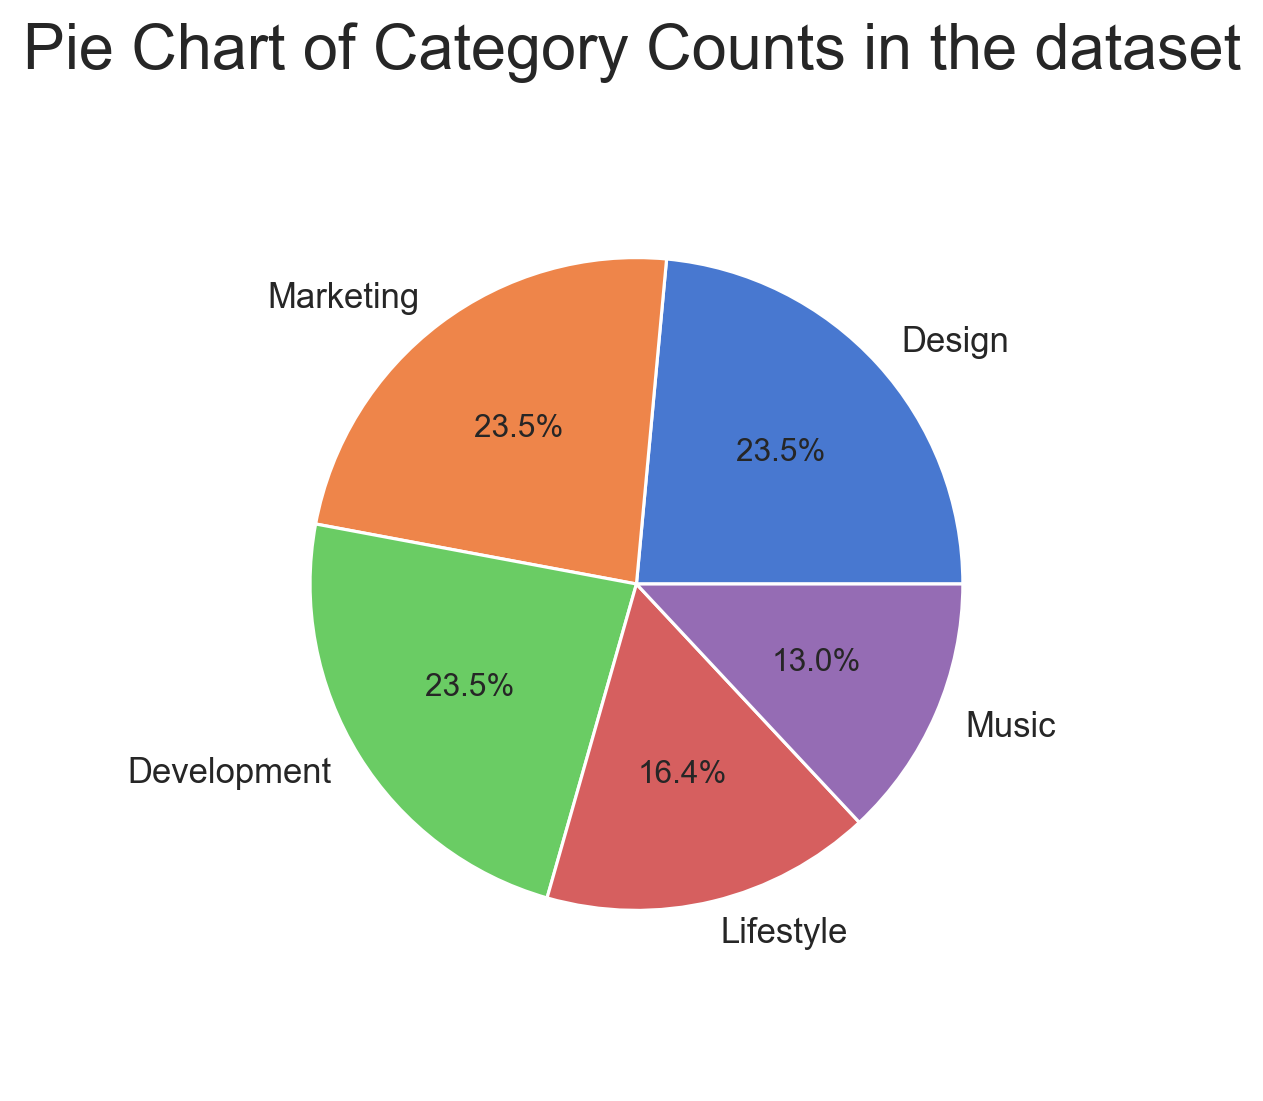

In [321]:

plt.figure(figsize= (5,5), dpi = 227)

plt.pie(
    # using data total)arrests
    cat_counts['counts'],
    # with the labels being officer names
    labels=cat_counts['Category'],
    # with the percent listed as a fraction
    autopct='%1.1f%%',
    radius=200

    )

# View the plot drop above
plt.axis('equal')
plt.title('Pie Chart of Category Counts in the dataset', size=20)
# View the plot
plt.tight_layout()
plt.show()

## Boxplots

### from these boxplots we can see that some subjects tend to be more pricier than others. Development skews highest while lifestyle skews lowest. 

CPU times: user 88.4 ms, sys: 6.29 ms, total: 94.7 ms
Wall time: 96.8 ms


Text(0.5, 1.0, 'Box Plots of Price Distribution by Subject')

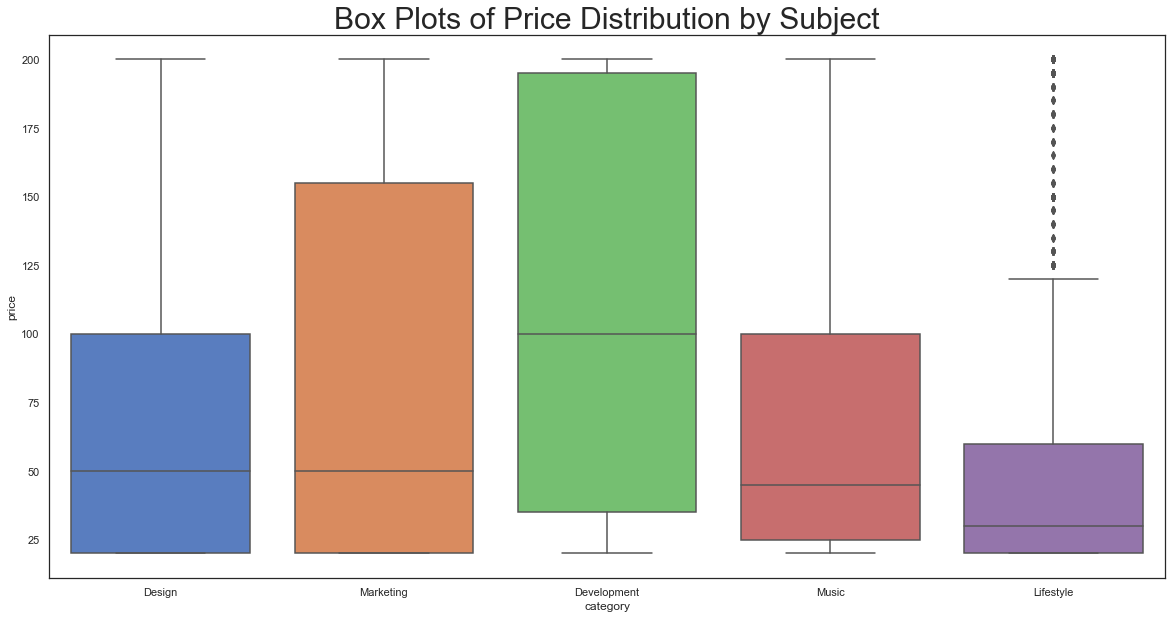

In [125]:
%%time

plt.figure(figsize=(20,10))
ax = sns.boxplot(x="category", y="price", data=data)
ax.set_title('Box Plots of Price Distribution by Subject', size=30)
#ax = sns.swarmplot(x="category", y="price", data=data, color='black', alpha=.4)

### from this overall boxplot we can see prices are skewed towards the lower half of distribution

CPU times: user 39.3 ms, sys: 3.61 ms, total: 42.9 ms
Wall time: 55.1 ms


Text(0.5, 1.0, 'Box Plot of Price Distribution for all subjects')

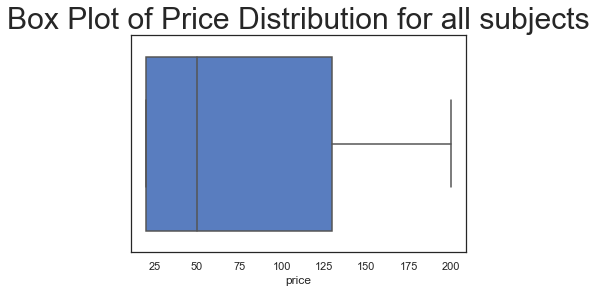

In [126]:
%%time

ax = sns.boxplot(data.price)
ax.set_title('Box Plot of Price Distribution for all subjects', size=30)
#ax = sns.swarmplot(data.price, color='black', alpha=.4)

# Segement data

### The upper cutoff for the low priced data section is half of the maximum data value, minus .01. The minus .01 is to include the common value of 99.99 in the high priced data section, in order to make the division of data slightly more even

In [190]:
data.price.describe()

count    20488.000000
mean        82.141259
std         67.604832
min         19.990000
25%         19.990000
50%         49.990000
75%        129.990000
max        199.990000
Name: price, dtype: float64

In [192]:
cutoff = round(data.price.max()/2-.01, 2)
cutoff

99.98

In [193]:
data['price_bracket_2']=0
for i in range(0, len(data)):
    if (data.price[i] <= (cutoff)):
        data['price_bracket_2'][i]=0
    else:
        data['price_bracket_2'][i]=1

In [194]:
data['price_bracket_2'].value_counts()

0    13220
1     8031
Name: price_bracket_2, dtype: int64

## visualize data segmentation

In [195]:
l = data[data.price_bracket_2==0]
h = data[data.price_bracket_2==1]


In [196]:
 l1.price.max()

94.99

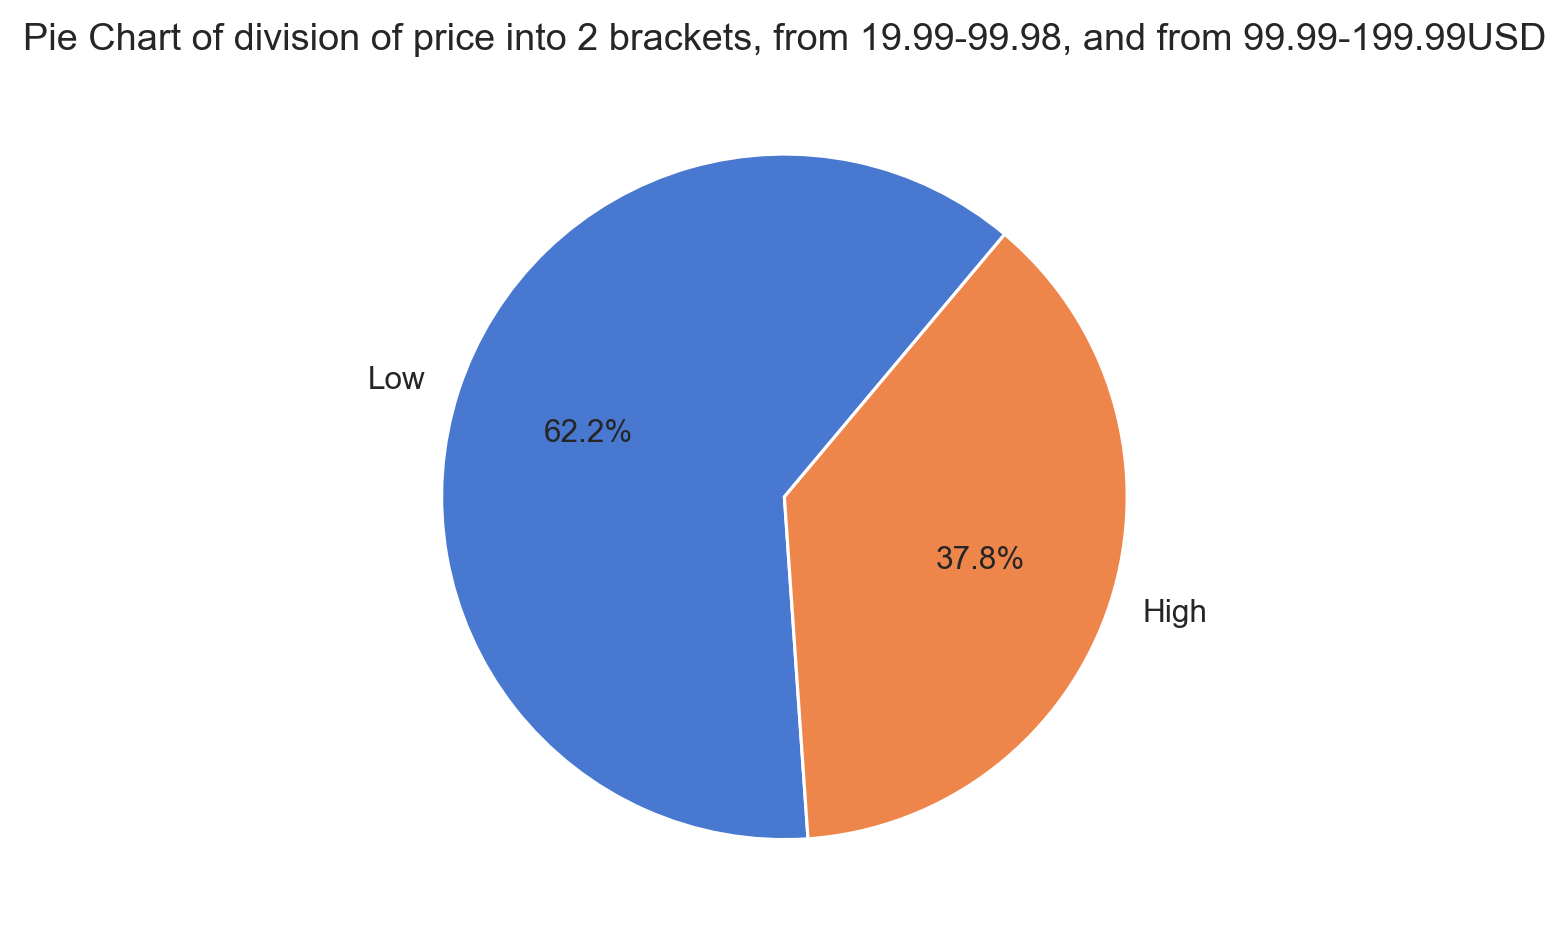

In [260]:
ll= len(l)
lh = len(h)
category_names = ['Low', 'High']
sizes = [ll, lh]
plt.figure(figsize= (5,5), dpi = 227)
plt.pie(sizes, labels=category_names, 
        textprops={'fontsize' :10} , startangle=50,
       autopct= '%1.1f%%')
plt.title('Pie Chart of division of price into 2 brackets, from {}-{}, and from {}-{}USD'.format(l.price.min(), 
                                                                                                 cutoff,
                                                                                                 h.price.min(),
                                                                                                 h.price.max(), size=10))

plt.show()

In [198]:
data.describe()

,id,price,price_bracket_2
count,2.125100e+04,20488.000000,21251.000000
mean,1.504849e+06,82.141259,0.377912
std,8.424740e+05,67.604832,0.484877
min,4.715000e+03,19.990000,0.000000
25%,8.030660e+05,19.990000,0.000000
50%,1.471462e+06,49.990000,0.000000
75%,2.226077e+06,129.990000,1.000000
max,3.171502e+06,199.990000,1.000000


### save as csv

In [200]:
data.to_csv('data/cleaned_data.csv')

# NLP Preprocessing

In [201]:
data = pd.read_csv('data/cleaned_data.csv')

### define stopwords

In [202]:
data.category.unique()

array(['Design', 'Marketing', 'Development', 'Music', 'Lifestyle'],
      dtype=object)

### These stopwords are chosen based on words that are seen to be common in all categories, but say little about the content of the course. They also include the names of the categories.

In [235]:
my_stopwords = ['a','the','and','of',
                'for','by','an', 'to',
                'in', 'learn', 'how', 'from', 'with', 
                'your', 'you', 'course', 'build', 'use', 'using',
                'on', 'this','that', 'get', 'or','is', 'create', 
                'guide', 'step','make','master','more','will','own',
               'skills', 'design', 'marketing', 'development', 'music', 'lifestyle',
               'it', 'all', 'can','complete']

### make function for cleaning and tokenizing

In [236]:
def clean_message(message,
                 stop_words=set(my_stopwords)):
    
    words = word_tokenize(message.lower())
    
    filtered_words =[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append((word))
        
    return filtered_words

# NLP Exploration

### create seperate dataframes for high priced and low priced courses

In [237]:
data.headline = data.headline.astype(str)


In [238]:
data.headline 

0        Learn the #1 most important building block of ...
1        Learn How to Draw People and Character Designs...
2        Use Blender to create beautiful 3D models for ...
3        Master Adobe Illustrator CC with this in-depth...
4        Understand your audience, envision a creative ...
                               ...                        
21246    To improve your drawing and sketching techniqu...
21247    Create 6 Step-By-Step Drawing & Watercolor Pai...
21248                                A Simple Moving Guide
21249    В этом курсе мы нарисуем эффектный скетч разны...
21250                    - Styles, brands, flavors & more!
Name: headline, Length: 21251, dtype: object

In [239]:
data_h = data[data.price_bracket_2 == 1]
data_h.reset_index(inplace=True)
data_l = data[data.price_bracket_2 == 0]
data_l.reset_index(inplace=True)


### create function to output unique words value counts, and the word list as a string

In [240]:
def unique_words(df):
    '''
    Parameters:
    df: dataframe with 'headline' column including course headlines to be processed

    Returns:
    as_string: words of headline column as string
    unique_words: a series of unique words in the df and their value counts
    '''
    df['words'] = 0
    total_words =[]
    for i in range(len(df['words'])):
        filtered_words = clean_message(df['headline'][i])
        df['words'][i] = filtered_words
        total_words.append(filtered_words)
    flat_list = [item for sublist in total_words for item in sublist]
    word_list = [''.join(word) for word in flat_list]
    as_string = ' '.join(word_list)
    unique_words= pd.Series(flat_list).value_counts()
    return as_string, unique_words

   


In [241]:
data.headline.dtype

dtype('O')

In [242]:

as_string_h, unique_words_h = unique_words(data_h)
as_string_l, unique_words_l = unique_words(data_l)
as_string, unique_words = unique_words(data)


In [243]:
type (unique_words_l)

pandas.core.series.Series

### create function to print information on unique words for high priced, low priced, and all courses

In [246]:
def print_unique(uw, subset):
    '''
    
    Parameters:
    uw: series of unique words, produced in unique_words function
    subset: description of the price bracket of uw

    Returns:
    None; outputs descriptive print statements'''
    
    print ('nr of unique words in {}:'.format(subset))
    print (uw.shape[0])
    print ('Top 10 unique words in {}:'.format(subset))
    print (uw.head(10))
    print ('________________')
    

In [247]:
print_unique(unique_words_h, 'courses priced from {} to {}'.format(h.price.min(),h.price.max()))
print_unique(unique_words_l, 'courses priced {} to {}'.format(l.price.min(),l.price.max()))
print_unique(unique_words, 'all courses')

nr of unique words in courses priced from 99.99 to 199.99:
7689
Top 10 unique words in courses priced from 99.99 to 199.99:
business     499
web          461
python       429
learning     385
scratch      377
facebook     361
data         343
seo          320
become       317
beginners    307
dtype: int64
________________
nr of unique words in courses priced 19.99 to 94.99:
10497
Top 10 unique words in courses priced 19.99 to 94.99:
business        661
easy            630
techniques      515
beginners       442
web             426
website         417
video           399
start           382
play            377
professional    376
dtype: int64
________________
nr of unique words in all courses:
12891
Top 10 unique words in all courses:
business      1160
web            887
easy           859
beginners      749
techniques     744
learning       729
website        710
facebook       696
start          676
scratch        663
dtype: int64
________________


# WordClouds

In [322]:
def word_cloud(icon, data, color_map, title):
    '''
    Parameters:
    image: image mask for worldcloud
    data: the string input of words to be included in wordcloud
    color_map: colormap for wordcloud
    title: title for worldcloud

    Returns:
    None; plots wordcloud
    
    '''
    
    image_mask= Image.new(mode='RGB', size=icon.size, color=(255,255,255))
    image_mask.paste(icon, box=icon)
    rgb_array=np.array(image_mask) #converts image object to array

    word_cloud = WordCloud(mask = rgb_array, background_color='white',
                          max_words=700, colormap=color_map)
    word_cloud.generate(data)
    plt.figure(figsize=[10,10])
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=30)
    plt.show()
    

In [323]:
#get image masks

response = requests.get("http://www.clker.com/cliparts/0/3/a/c/11949869011705644705arrow07_4.svg.hi.png")
img_high = Image.open(BytesIO(response.content))

response = requests.get("http://www.clker.com/cliparts/9/a/2/1/1194986900831913211arrow07_2.svg.hi.png")
img_low = Image.open(BytesIO(response.content))

response = requests.get("http://www.clker.com/cliparts/Z/D/C/K/B/D/chocolate-donut-revised-hi.png")
img = Image.open(BytesIO(response.content))

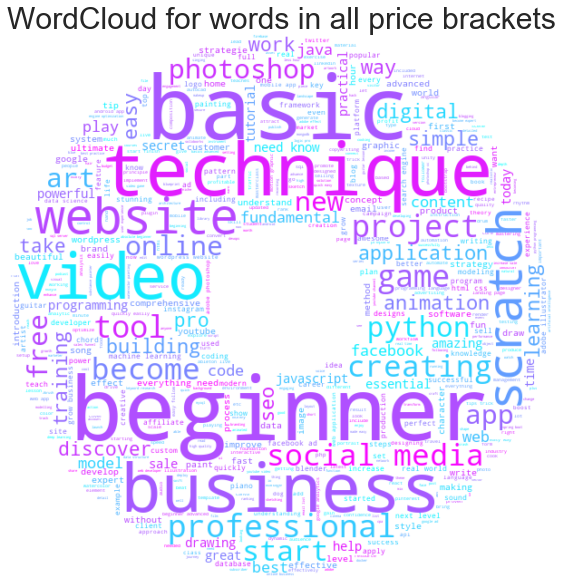

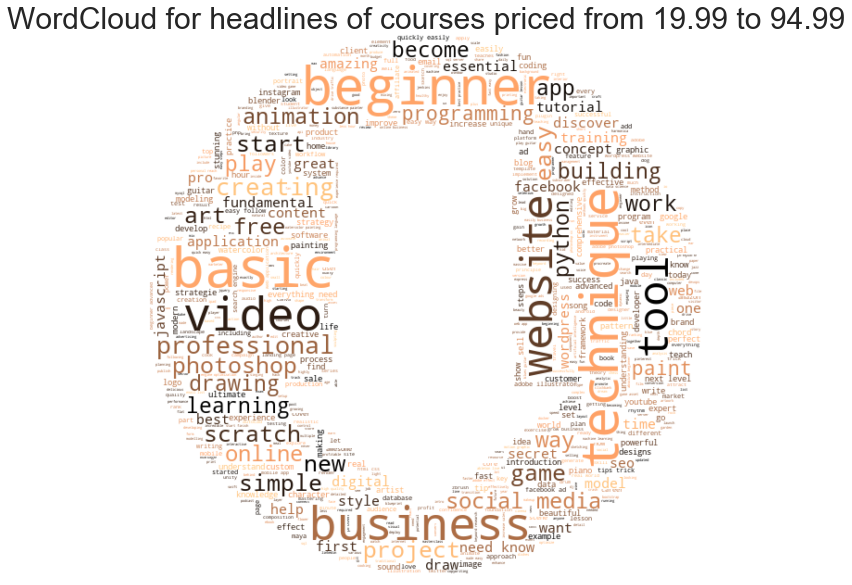

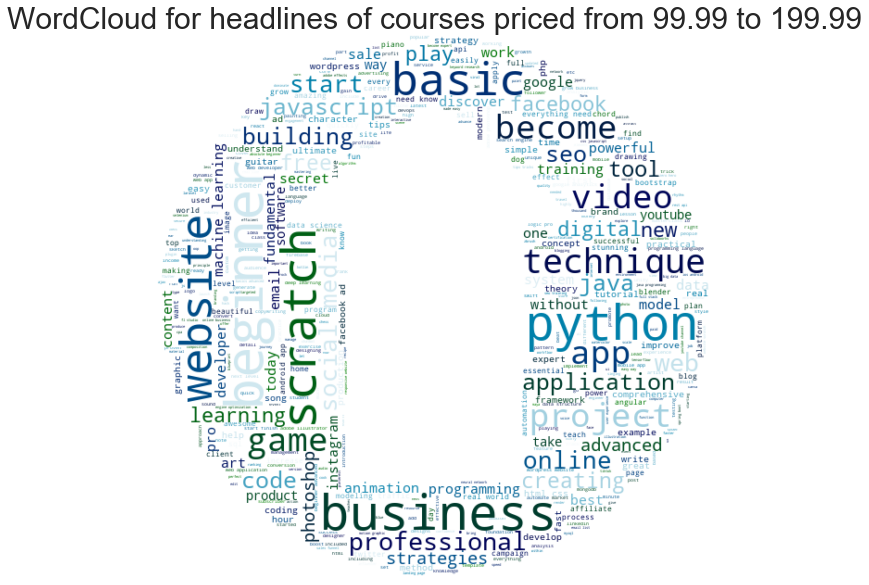

In [324]:
word_cloud(img, as_string, 'cool', 'WordCloud for words in all price brackets' )
word_cloud(img_low, as_string_l, 'copper', 'WordCloud for headlines of courses priced from {} to {}'.format(l.price.min(), l.price.max()))

word_cloud(img_high, as_string_h, 'ocean', 'WordCloud for headlines of courses priced from {} to {}'.format(h.price.min(), h.price.max())) 


# Generate and Evaluate Predictive Models

### Creating function 

In [311]:
def pred_mod(data, prices, classifier, classifier_name):
    '''Parameters:
    data: dataframe of interest
    prices: price data, segmented into high/low price binary
    classifier: model to be run
    classifier_name: name of model

    Returns:
    None; prints information on model results
    '''
    
    vectorizer =  CountVectorizer(stop_words=set(my_stopwords))
    all_features = vectorizer.fit_transform(data.headline)

    X_train, X_test, y_train, y_test = train_test_split(all_features,
                                                       prices,
                                                       test_size=0.2,
                                                       random_state=100)

    classifier = classifier()
    classifier.fit(X_train,y_train)
    

    y_hat = (classifier.predict(X_test))
    nr_corr = (y_test == y_hat).sum()
    preds = classifier.predict(X_test)

    number_wrong = sum(abs(y_hat - y_test))
    fraction_wrong = (number_wrong/(len(y_test)))
    price_brackets = len(prices.unique())
    accuracy = (1- fraction_wrong)
    # calculate null accuracy in a single line of code
    # only for binary classification problems coded as 0/1
    baseline = max(y_test.mean(), 1 - y_test.mean())
    higher = accuracy-baseline


    print (' ')
    print ("this {} model includes these course categories {}".format(classifier_name, data.category.unique()))
    print (' ')
    print ("the baseline accuracy would be {:.1%}".format(baseline))
    print ("the accuracy of this {} model is {:.2%}".format(classifier_name, accuracy))
    print ("**the accuracy is {:.1%} higher than baseline**".format(higher))
    print (' ')

    print ("the percent of predictions the model gets wrong is {:.2%}".format(fraction_wrong))
    print ("the recall is {:.2%}".format(recall_score(y_test, preds, average='weighted')))
    print ("the precision is {:.2%}".format(precision_score(y_test, preds, average='weighted')))



### setting categories and models

In [312]:
categories=['Design','Marketing','Development','Music','Lifestyle']

#can add models
models=[LogisticRegression, MultinomialNB]
model_names=['LogisticRegression', 'Multinomial Naive Bayes']


### running models for entire dataframe

In [313]:

for j in range(len(models)):
    pred_mod(data, data.price_bracket_2, models[j], model_names[j])
    print ('_____________')


 
this LogisticRegression model includes these course categories ['Design' 'Marketing' 'Development' 'Music' 'Lifestyle']
 
the baseline accuracy would be 62.7%
the accuracy of this LogisticRegression model is 67.30%
**the accuracy is 4.6% higher than baseline**
 
the percent of predictions the model gets wrong is 32.70%
the recall is 67.30%
the precision is 66.20%
_____________
 
this Multinomial Naive Bayes model includes these course categories ['Design' 'Marketing' 'Development' 'Music' 'Lifestyle']
 
the baseline accuracy would be 62.7%
the accuracy of this Multinomial Naive Bayes model is 65.56%
**the accuracy is 2.8% higher than baseline**
 
the percent of predictions the model gets wrong is 34.44%
the recall is 65.56%
the precision is 65.55%
_____________


### running models segmented by category

In [314]:
for j in range(len(models)):
    for i in categories:
        data_n = 'data{}'.format(i)
        data_n=data[data['category']==i]
        pred_mod(data_n, data_n.price_bracket_2, models[j], model_names[j])
        print ('_____________')

    

 
this LogisticRegression model includes these course categories ['Design']
 
the baseline accuracy would be 69.3%
the accuracy of this LogisticRegression model is 71.70%
**the accuracy is 2.4% higher than baseline**
 
the percent of predictions the model gets wrong is 28.30%
the recall is 71.70%
the precision is 69.33%
_____________
 
this LogisticRegression model includes these course categories ['Marketing']
 
the baseline accuracy would be 57.4%
the accuracy of this LogisticRegression model is 60.90%
**the accuracy is 3.5% higher than baseline**
 
the percent of predictions the model gets wrong is 39.10%
the recall is 60.90%
the precision is 60.14%
_____________
 
this LogisticRegression model includes these course categories ['Development']
 
the baseline accuracy would be 54.4%
the accuracy of this LogisticRegression model is 60.80%
**the accuracy is 6.4% higher than baseline**
 
the percent of predictions the model gets wrong is 39.20%
the recall is 60.80%
the precision is 60.86